# Notes, Work, and Code

## Preparation

In [154]:
### IMPORTED PACKAGES ###

library(ggplot2) # data visualization
library(tidyverse) # dataset manipulation (includes dplyr)

# PCA calculation and visualization
library(factoextra)
library(FactoMineR)

In [155]:
### MAIN DATAFRAMES ###

# load dataset
sharks = read.table("datasets/shark_immunity.txt", header = TRUE, sep = "\t")

# change the order the physiological conditions are displayed 
sharks$physiological_condition <- factor(
  sharks$physiological_condition,
  levels = c("Healthy", "Stressed", "Injured", "Infected", "Recovering")
)
# reduces name to just the gene
names(sharks) <- sub("_expression", "", names(sharks))
# add identification based on immune cell type and physiological condition
sharks$group = paste(sharks$physiological_condition, sharks$immune_cell_type, sep="_")

# dataframe with gene expression split into 2 variables
shark_genes = sharks %>% 
    pivot_longer(
        cols = starts_with("Gene_"),
        names_to = "gene",
        values_to = "expression"
    )
    
# dataframe where all numerical variables are split into 2 variables
sharks_super_long = sharks %>%
    select(physiological_condition, immune_cell_type, Gene_A, Gene_B, Gene_C, Gene_D, Gene_E, Gene_F, regeneration_capacity, age_years, immune_receptor_diversity, response_to_infection, inflammation_level, weight_kg, habitat_location,resilience_score, reproduction_rate, group) %>% 
  
    pivot_longer(
        cols = -c("physiological_condition","immune_cell_type","Gene_A","Gene_B","Gene_C","Gene_D","Gene_E","Gene_F","habitat_location", "group"), 
        names_to = "variable", 
        values_to = "value") %>%
    
        select(physiological_condition, immune_cell_type, Gene_A, Gene_B, Gene_C, Gene_D, Gene_E, Gene_F,habitat_location,group,variable,value) %>% 
    
        pivot_longer(
            cols = -c("physiological_condition","immune_cell_type","habitat_location","group","variable","value"),
            names_to = "gene",
            values_to = "expression")

In [156]:
### DATA SELECTION FUNCTIONS ###
condition_data = function(data, condition) { data[data$physiological_condition==condition, ] }

cell_data = function(data, cell_type) { data[data$immune_cell_type==cell_type, ] }

## 1. Immune Response Profiles of Different Immune Cell Types in the Infected Condition

How does the immune response profile differ from one cell type to another in the infected condition? 

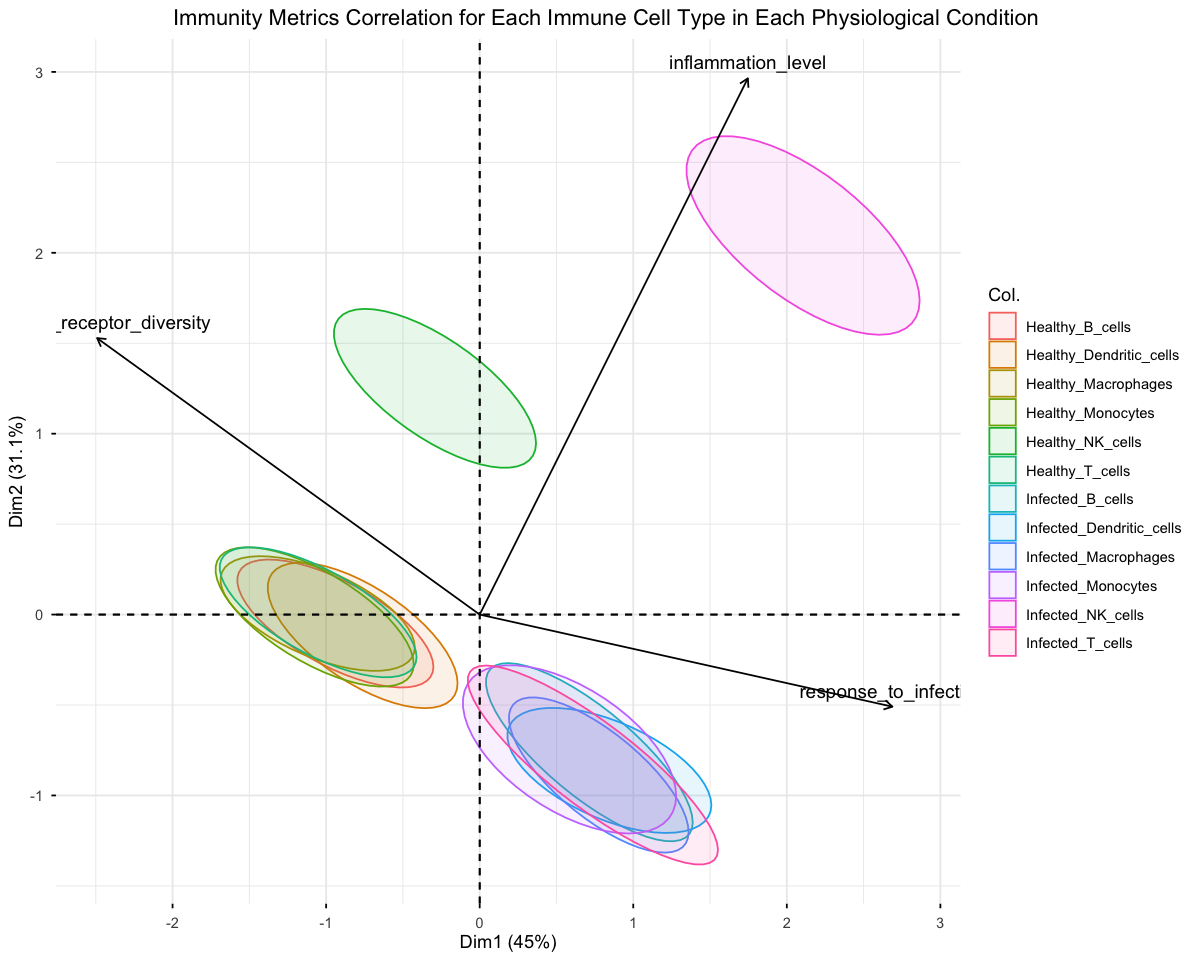

In [157]:
# healthy and infected population
healthy_infected = sharks %>% filter(physiological_condition %in% c("Healthy", "Infected"))

# PCA on response to infection, inflammation level, and immune receptor diversity metrics
h_inf_pca <- PCA(healthy_infected[c("response_to_infection","inflammation_level","immune_receptor_diversity")], scale.unit=TRUE, graph=FALSE)

# customize graph size
options(repr.plot.width=10, repr.plot.height=8)

# MDS cloud plot with correlation circle
fviz_pca_biplot(h_inf_pca, geom.ind="None", col.ind=healthy_infected$group, col.var="black", addEllipses=TRUE, ellipse.level=0.5, title="Immunity Metrics Correlation for Each Immune Cell Type in Each Physiological Condition") +
    theme(plot.title=element_text(hjust=3))


To properly determine the immune response profile of different immune cells types in the infectd condition, I need to compare it to that of the healthy condition.

It seems that the NK cells are distiguished from other immune cell types by their inflammation level. 

It also seems that the difference between the healthy and infected conditions is that the healthy cells are more correlated with immune receptor diversity while the infected cells are more correlated with response to infection, which is also true for NK cells.

### Inflammation Level Profile

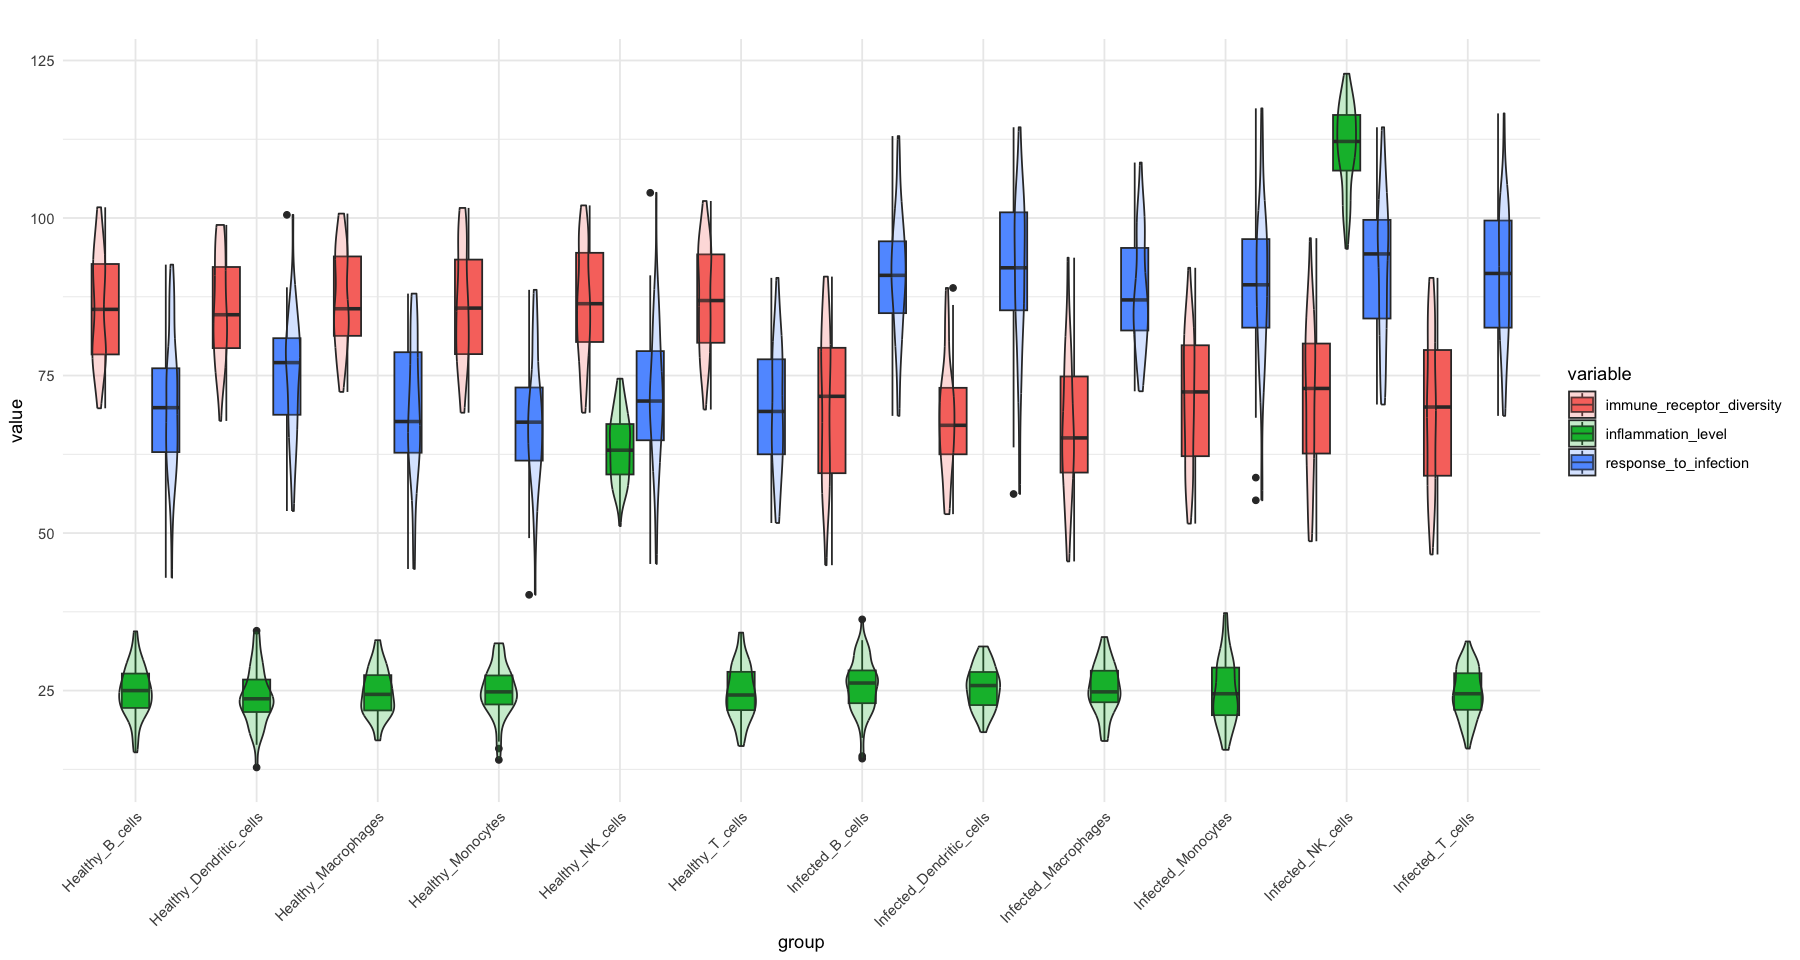

In [158]:
# long dataframe for healthy and infected populations on immune response metrics
h_inf_immune = healthy_infected[c("physiological_condition","immune_cell_type","immune_receptor_diversity","response_to_infection","inflammation_level","group")] %>%
    pivot_longer(
        cols = -c("physiological_condition","immune_cell_type","group"),
        names_to = "variable",
        values_to = "value"
    )

# customize graph size
options(repr.plot.width=15, repr.plot.height=8)

ggplot(h_inf_immune, aes(x=group, y=value, fill=variable)) +
    geom_boxplot() +
    geom_violin(alpha=0.25) +
    theme_minimal() +
    theme(
        axis.text.x=element_text(angle=45, hjust=1),
        plot.title=element_text(hjust=8)
    ) +
    ggtitle("Immune Response Levels Across Immune Cell Types in Healthy and Infected Conditions")

It seems that all immune cell types except NK cells had very similar inflammation levels, regardless of whether they were in healthy or infected conditions.

It also seems as though the infection response and immune receptor diversity profiles reverse between the healthy and infected conditions.

In [159]:
# select inflammation levels for healthy and infected populations
h_inf_inflam = h_inf_immune[h_inf_immune$variable=="inflammation_level", ]

# test the normality of the inflammation level data for healthy and infected populations
h_inf_inflam %>%
    group_by(group) %>%
    summarise(p_value = shapiro.test(value)$p.value)

group,p_value
<chr>,<dbl>
Healthy_B_cells,0.90525866
Healthy_Dendritic_cells,0.53154464
Healthy_Macrophages,0.65941410
Healthy_Monocytes,0.41745223
Healthy_NK_cells,0.38072358
Healthy_T_cells,0.46554625
Infected_B_cells,0.52597683
Infected_Dendritic_cells,0.86273029
Infected_Macrophages,0.97692907


The Shapiro-Wilks test confirms that the inflammation levels are normally distributed for each immune cell type in either healthy or infected conditions.

In [160]:
# anova on the inflammation levels
h_inf_inflam_anova = aov(data=healthy_infected, inflammation_level ~ group)
summary(h_inf_inflam_anova)

             Df Sum Sq Mean Sq F value Pr(>F)    
group        11 492138   44740    2142 <2e-16 ***
Residuals   708  14789      21                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

ANOVA confirms that a statistical difference exists between the groups (physiological conditio-immune cell type).

In [161]:
# Tukey HSD post hoc test on the inflammation levels
h_inf_inflam_tukey = TukeyHSD(h_inf_inflam_anova)$group
head(h_inf_inflam_tukey)

,diff,lwr,upr,p adj
Healthy_Dendritic_cells-Healthy_B_cells,-0.79869478,-3.516269,1.918880,0.9983427
Healthy_Macrophages-Healthy_B_cells,-0.21343837,-3.122910,2.696033,1.0000000
Healthy_Monocytes-Healthy_B_cells,0.04472627,-2.533334,2.622786,1.0000000
Healthy_NK_cells-Healthy_B_cells,38.84477369,36.448699,41.240849,0.0000000
Healthy_T_cells-Healthy_B_cells,-0.15664052,-2.462647,2.149366,1.0000000
Infected_B_cells-Healthy_B_cells,0.83271548,-1.649507,3.314938,0.9946525


The Tukey HSD post hoc test identifies between which pairs a statistical difference exists. If the p adj value is less than 0.05, then the concerned pair has a statistical difference.

In [162]:
# get the list of pairs that have a p adj value less than 0.05
inflam_diff_res = h_inf_inflam_tukey[h_inf_inflam_tukey[,"p adj"] < 0.05, "p adj"]

# get pair names (no need for the p adj value)
inflam_pair_lst = as.list(names(inflam_diff_res))

In [163]:
# check in NK cells actually are involved in every pair
not_NK = logical()
has_NK = logical()
for (p in inflam_pair_lst) {
    ps = str_split_fixed(p, "-", 2)
    a = str_split_fixed(ps[1], "_", 2)
    b = str_split_fixed(ps[2], "_", 2)
    if (a[2] != "NK_cells" && b[2] != "NK_cells") { not_NK = c(not_NK, TRUE) }
    if (a[2] == "NK_cells" || b[2] == "NK_cells") { has_NK = c(has_NK, TRUE) }
}

sprintf("%d pairs where p adj < 0.05", length(inflam_pair_lst))
sprintf("%d pairs neither cell type is not an NK cell.", length(not_NK))
sprintf("%d pairs where at least one cell type is an NK cell.", length(has_NK))
if (length(has_NK) == length(inflam_pair_lst)) { sprintf("All pairs where p adj < 0.05 have at least one cell type that is an NK cell.") 
} else { sprintf("Not all pairs were p adj < 0.05 have a cell type that is an NK cell.") }

[1] "21 pairs where p adj < 0.05"

[1] "0 pairs neither cell type is not an NK cell."

[1] "21 pairs where at least one cell type is an NK cell."

[1] "All pairs where p adj < 0.05 have at least one cell type that is an NK cell."

>I had assumed that all pairs whose p adj value were less than 0.05 would naturally have at least one cell type that was an NK cell, but this could have been careless assumption, especially with the following data manipulation.
>
>However, the code above confirms that all the pairs with a statistical difference have at least an NK cell involved.

In [164]:
# create lists of "partner" cell types, separating them based on whether they were paired with a healthy or infected NK cell
healthy_NK = list(); infected_NK = list()
h = 1; i = 1

for (p in inflam_pair_lst) {
    ps = str_split_fixed(paste(p),"-",2)
    if (ps[1] == "Healthy_NK_cells") { 
        healthy_NK[[h]] = ps[2]
        h = h + 1
    }
    if (ps[2] == "Healthy_NK_cells") { 
        healthy_NK[[h]] = ps[1]
        h = h + 1
    }
    if (ps[1] == "Infected_NK_cells") { 
        infected_NK[[i]] = ps[2]
        i = i + 1
    }
    if (ps[2] == "Infected_NK_cells") { 
        infected_NK[[i]] = ps[1]
        i = i + 1
    }
}


# create sublists of "partner" cell types, separating them further based on whether they themselves were healthy or infected
healthy_NK_h = list(); healthy_NK_i = list()
h = 1; i = 1

for (x in healthy_NK) {
    aux = str_split_fixed(x,"_",2)
    if (aux[1] == "Healthy") { 
        healthy_NK_h[h] = aux[2]
        h = h + 1
    }
    if (aux[2] == "Healthy") { 
        healthy_NK_h[h] = aux[1]
        h = h + 1
    }
    if (aux[1] == "Infected") { 
        healthy_NK_i[i] = aux[2]
        i = i + 1
    }
    if (aux[2] == "Infected") { 
        healthy_NK_i[i] = aux[1]
        i = i + 1
    }
}

infected_NK_h = list(); infected_NK_i = list()
h = 1; i = 1
for (x in infected_NK) {
    aux = str_split_fixed(x,"_",2)
    if (aux[1] == "Healthy") { 
        infected_NK_h[h] = aux[2]
        h = h + 1
    }
    if (aux[2] == "Healthy") { 
        infected_NK_h[h] = aux[1]
        h = h + 1
    }
    if (aux[1] == "Infected") { 
        infected_NK_i[i] = aux[2]
        i = i + 1
    }
    if (aux[2] == "Infected") { 
        infected_NK_i[i] = aux[1]
        i = i + 1
    }
}

# concatenate all the sublists for easy looping
partner_groups = list(healthy_NK_h, healthy_NK_i, infected_NK_h, infected_NK_i)

# get all cell types as a list
cell_types = as.list(unique(sharks$immune_cell_type))

# check that all the sublists contain all the cell types
res = logical()
for (g in partner_groups) {
    for (t in cell_types) {
        res = c(res, t %in% g)
    }
}

# create a true-false matrix 
partner_matrix = matrix(
    res,
    nrow = length(partner_groups),
    ncol = length(cell_types),
    byrow = TRUE
)
# left letter represents the NK cell; right letter represents the varying cell type
rownames(partner_matrix) = c("H - H", "H - I", "I - H", "I - I")
colnames(partner_matrix) = cell_types

partner_matrix

,Monocytes,Dendritic_cells,T_cells,NK_cells,B_cells,Macrophages
H - H,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
H - I,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
I - H,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
I - I,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE


This true-false matrix shows the cells with which NK cells have a statistical difference in inflammation level in combinations of healthy and infected conditions.

Quick things to note :
1. There are 24 elements in this matrix whereas we started with 21 pairs. This is comes from the Healthy NK - Healthy NK and Infected NK - Infected NK pairs that count for 2 and the Healthy NK - Infected NK and the Infected NK - Healthy NK that is actually only 1 pair, accounting for our 3 extra pairs.

2. Additionally, the Healthy NK - Healthy NK and Infected NK - Infected NK pairs are shown to have no statistical difference (FALSE), which is logical since they cannot differ from themselves.

There are thus 3 things we can conclude : 

1. Remembering from the boxpot graph that NK cells were shown to have higher inflammation levels, we can conclude that this elevated level compared to all other cell types, whether either the NK cell or the concerned cell type be healthy or infected, is significantly higher (different).

2. Furthermore, the inflammation level of infected NK cells is shown to be significantly higher than that of healthy NK cells. 

3. As no non-NK cell - non-NK cell pair was selected, the inflammation levels of every cell type compared with each other are statistically similar, even when comparing between the healthy and infected conditions.

Therefore, the immune reponse profile between the healthy and infected conditions, in terms of the inflammation level, is defined by the NK cells' higher inflammation level.

### [WIP] Immune Response Profile

In [165]:
h_inf_resp = h_inf_immune[h_inf_immune$variable=="response_to_infection", ]
h_inf_resp %>%
    group_by(group) %>%
    summarise(p_value = shapiro.test(value)$p.value)

group,p_value
<chr>,<dbl>
Healthy_B_cells,0.38110251
Healthy_Dendritic_cells,0.71980928
Healthy_Macrophages,0.31956204
Healthy_Monocytes,0.64377979
Healthy_NK_cells,0.93212107
Healthy_T_cells,0.17071049
Infected_B_cells,0.92177458
Infected_Dendritic_cells,0.30026314
Infected_Macrophages,0.26508931


In [166]:
h_inf_resp_anova = aov(data=healthy_infected, response_to_infection ~ group)
summary(h_inf_inflam_anova)

             Df Sum Sq Mean Sq F value Pr(>F)    
group        11 492138   44740    2142 <2e-16 ***
Residuals   708  14789      21                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [167]:
h_inf_resp_tukey = TukeyHSD(h_inf_resp_anova)$group
head(h_inf_resp_tukey)

,diff,lwr,upr,p adj
Healthy_Dendritic_cells-Healthy_B_cells,4.3738705,-1.951641,10.699382,0.5010736
Healthy_Macrophages-Healthy_B_cells,-0.8724436,-7.644619,5.899732,0.9999996
Healthy_Monocytes-Healthy_B_cells,-2.8102304,-8.811003,3.190543,0.9302836
Healthy_NK_cells-Healthy_B_cells,1.2003908,-4.376788,6.777570,0.9999159
Healthy_T_cells-Healthy_B_cells,-0.5908098,-5.958343,4.776723,0.9999999
Infected_B_cells-Healthy_B_cells,20.3624282,14.584731,26.140126,0.0000000


In [168]:
as.list(names(h_inf_resp_tukey[h_inf_resp_tukey[, "p adj"] < 0.05, "p adj"]))

[[1]]
[1] "Infected_B_cells-Healthy_B_cells"

[[2]]
[1] "Infected_Dendritic_cells-Healthy_B_cells"

[[3]]
[1] "Infected_Macrophages-Healthy_B_cells"

[[4]]
[1] "Infected_Monocytes-Healthy_B_cells"

[[5]]
[1] "Infected_NK_cells-Healthy_B_cells"

[[6]]
[1] "Infected_T_cells-Healthy_B_cells"

[[7]]
[1] "Healthy_Monocytes-Healthy_Dendritic_cells"

[[8]]
[1] "Infected_B_cells-Healthy_Dendritic_cells"

[[9]]
[1] "Infected_Dendritic_cells-Healthy_Dendritic_cells"

[[10]]
[1] "Infected_Macrophages-Healthy_Dendritic_cells"

[[11]]
[1] "Infected_Monocytes-Healthy_Dendritic_cells"

[[12]]
[1] "Infected_NK_cells-Healthy_Dendritic_cells"

[[13]]
[1] "Infected_T_cells-Healthy_Dendritic_cells"

[[14]]
[1] "Infected_B_cells-Healthy_Macrophages"

[[15]]
[1] "Infected_Dendritic_cells-Healthy_Macrophages"

[[16]]
[1] "Infected_Macrophages-Healthy_Macrophages"

[[17]]
[1] "Infected_Monocytes-Healthy_Macrophages"

[[18]]
[1] "Infected_NK_cells-Healthy_Macrophages"

[[19]]
[1] "Infected_T_cells-Healthy_Macrophages"

[[20]]
[1] "Infected_B_cells-Healthy_Monocytes"

[[21]]
[1] "Infected_Dendritic_cells-Healthy_Monocytes"

[[22]]
[1] "Infected_Macrophages-Healthy_Monocytes"

[[23]]
[1] "Infected_Monocytes-Healthy_Monocytes"

[[24]]
[1] "Infected_NK_cells-Healthy_Monocytes"

[[25]]
[1] "Infected_T_cells-Healthy_Monocytes"

[[26]]
[1] "Infected_B_cells-Healthy_NK_cells"

[[27]]
[1] "Infected_Dendritic_cells-Healthy_NK_cells"

[[28]]
[1] "Infected_Macrophages-Healthy_NK_cells"

[[29]]
[1] "Infected_Monocytes-Healthy_NK_cells"

[[30]]
[1] "Infected_NK_cells-Healthy_NK_cells"

[[31]]
[1] "Infected_T_cells-Healthy_NK_cells"

[[32]]
[1] "Infected_B_cells-Healthy_T_cells"

[[33]]
[1] "Infected_Dendritic_cells-Healthy_T_cells"

[[34]]
[1] "Infected_Macrophages-Healthy_T_cells"

[[35]]
[1] "Infected_Monocytes-Healthy_T_cells"

[[36]]
[1] "Infected_NK_cells-Healthy_T_cells"

[[37]]
[1] "Infected_T_cells-Healthy_T_cells"

In [169]:
pair_presence_matrix = function(tukey_res) {
    p_adj = tukey_res[tukey_res[, "p adj"] < 0.05, "p adj"]
    pair_lst = as.list(names(p_adj))

    h_cell_types = c(); i_cell_types = c()
    for (t in cell_types) {
        h_cell_types = c(h_cell_types,paste("Healthy_",t,sep=""))
        i_cell_types = c(i_cell_types,paste("Infected_",t,sep=""))    
    }
    h_i_cell_types = c(h_cell_types, i_cell_types)

    res_mat = matrix(
        ".",
        nrow = length(cell_types) * 2,
        ncol = length(cell_types) * 2,
        byrow = TRUE
    )
    rownames(res_mat) = h_i_cell_types
    colnames(res_mat) = h_i_cell_types

    for (x in h_i_cell_types) {
        for (y in h_i_cell_types) {
            if (x == y) {
                res_mat[x,y] = "|"
            }
        }
    }

    for (p in pair_lst) {
        aux = str_split_fixed(paste(p),"-",2)
        res_mat[aux[1],aux[2]] = "O"
        res_mat[aux[2],aux[1]] = "O"
    }
    return (res_mat)
}

In [170]:
pair_presence_matrix(h_inf_resp_tukey)

,Healthy_Monocytes,Healthy_Dendritic_cells,Healthy_T_cells,Healthy_NK_cells,Healthy_B_cells,Healthy_Macrophages,Infected_Monocytes,Infected_Dendritic_cells,Infected_T_cells,Infected_NK_cells,Infected_B_cells,Infected_Macrophages
Healthy_Monocytes,|,O,.,.,.,.,O,O,O,O,O,O
Healthy_Dendritic_cells,O,|,.,.,.,.,O,O,O,O,O,O
Healthy_T_cells,.,.,|,.,.,.,O,O,O,O,O,O
Healthy_NK_cells,.,.,.,|,.,.,O,O,O,O,O,O
Healthy_B_cells,.,.,.,.,|,.,O,O,O,O,O,O
Healthy_Macrophages,.,.,.,.,.,|,O,O,O,O,O,O
Infected_Monocytes,O,O,O,O,O,O,|,.,.,.,.,.
Infected_Dendritic_cells,O,O,O,O,O,O,.,|,.,.,.,.
Infected_T_cells,O,O,O,O,O,O,.,.,|,.,.,.
Infected_NK_cells,O,O,O,O,O,O,.,.,.,|,.,.


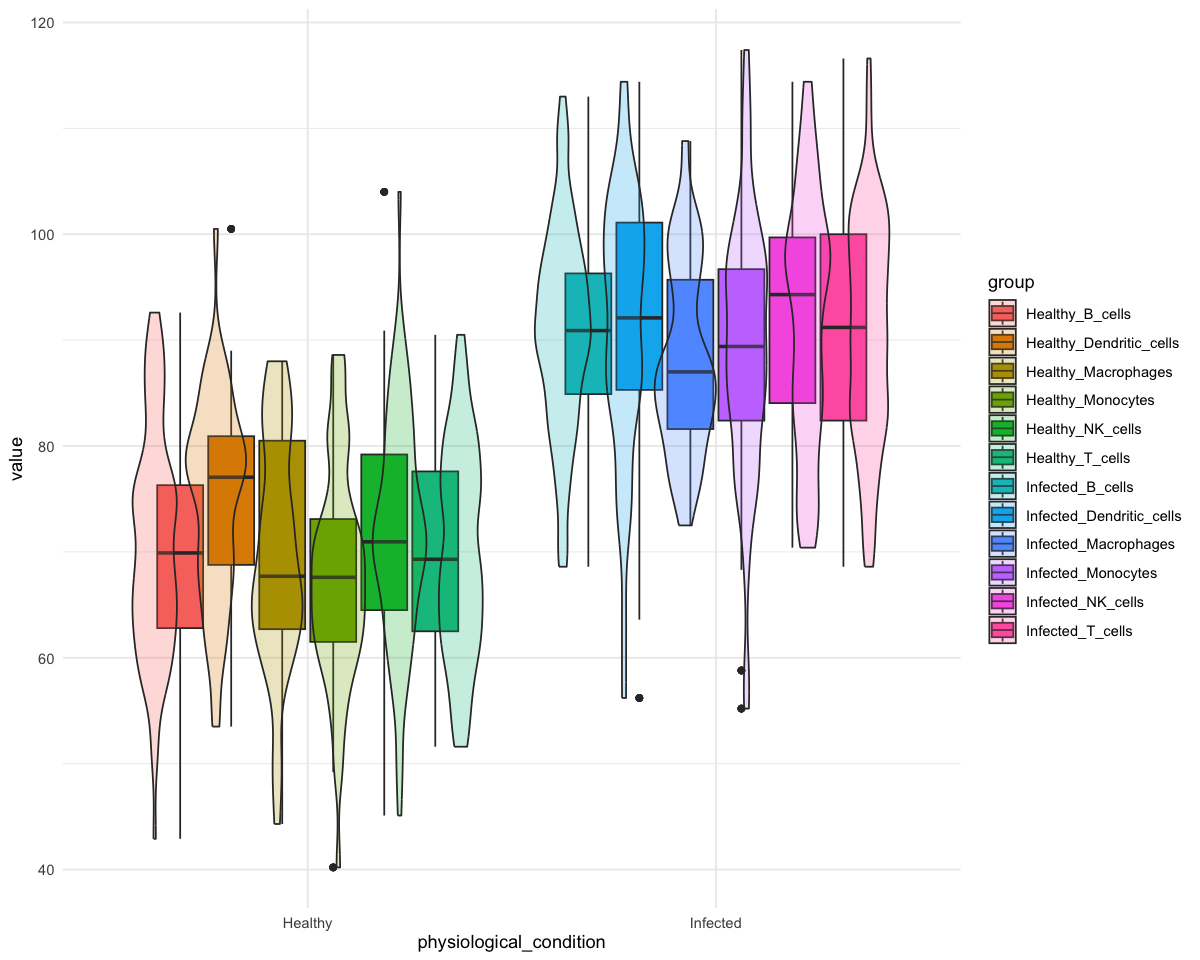

In [185]:
h_inf_resp_long = sharks_super_long %>%
    filter(physiological_condition %in% c("Healthy","Infected")) %>%
    filter(variable == "response_to_infection")
    
ggplot(h_inf_resp_long, aes(x=physiological_condition, y=value, fill=group)) +
    geom_boxplot() +
    geom_violin(alpha=0.25) +
    theme_minimal()

### [WIP] Immune Receptor Diversity Profiles

In [173]:
h_inf_div = h_inf_immune[h_inf_immune$variable=="response_to_infection", ]
h_inf_div %>%
    group_by(group) %>%
    summarise(p_value = shapiro.test(value)$p.value)

group,p_value
<chr>,<dbl>
Healthy_B_cells,0.38110251
Healthy_Dendritic_cells,0.71980928
Healthy_Macrophages,0.31956204
Healthy_Monocytes,0.64377979
Healthy_NK_cells,0.93212107
Healthy_T_cells,0.17071049
Infected_B_cells,0.92177458
Infected_Dendritic_cells,0.30026314
Infected_Macrophages,0.26508931


In [174]:
h_inf_div_anova = aov(data=healthy_infected, immune_receptor_diversity ~ group)
summary(h_inf_div_anova)

             Df Sum Sq Mean Sq F value Pr(>F)    
group        11  48589    4417   44.73 <2e-16 ***
Residuals   708  69920      99                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [175]:
h_inf_div_tukey = TukeyHSD(h_inf_div_anova)$group
head(h_inf_div_tukey)

,diff,lwr,upr,p adj
Healthy_Dendritic_cells-Healthy_B_cells,0.1690010,-5.739903,6.077905,1.0000000
Healthy_Macrophages-Healthy_B_cells,1.5069818,-4.819169,7.833133,0.9997718
Healthy_Monocytes-Healthy_B_cells,0.1658212,-5.439733,5.771375,1.0000000
Healthy_NK_cells-Healthy_B_cells,0.7454087,-4.464450,5.955267,0.9999987
Healthy_T_cells-Healthy_B_cells,1.7315495,-3.282471,6.745569,0.9931545
Infected_B_cells-Healthy_B_cells,-14.9581464,-20.355317,-9.560976,0.0000000


In [176]:
as.list(names(h_inf_div_tukey[h_inf_div_tukey[, "p adj"] < 0.05, "p adj"]))

[[1]]
[1] "Infected_B_cells-Healthy_B_cells"

[[2]]
[1] "Infected_Dendritic_cells-Healthy_B_cells"

[[3]]
[1] "Infected_Macrophages-Healthy_B_cells"

[[4]]
[1] "Infected_Monocytes-Healthy_B_cells"

[[5]]
[1] "Infected_NK_cells-Healthy_B_cells"

[[6]]
[1] "Infected_T_cells-Healthy_B_cells"

[[7]]
[1] "Infected_B_cells-Healthy_Dendritic_cells"

[[8]]
[1] "Infected_Dendritic_cells-Healthy_Dendritic_cells"

[[9]]
[1] "Infected_Macrophages-Healthy_Dendritic_cells"

[[10]]
[1] "Infected_Monocytes-Healthy_Dendritic_cells"

[[11]]
[1] "Infected_NK_cells-Healthy_Dendritic_cells"

[[12]]
[1] "Infected_T_cells-Healthy_Dendritic_cells"

[[13]]
[1] "Infected_B_cells-Healthy_Macrophages"

[[14]]
[1] "Infected_Dendritic_cells-Healthy_Macrophages"

[[15]]
[1] "Infected_Macrophages-Healthy_Macrophages"

[[16]]
[1] "Infected_Monocytes-Healthy_Macrophages"

[[17]]
[1] "Infected_NK_cells-Healthy_Macrophages"

[[18]]
[1] "Infected_T_cells-Healthy_Macrophages"

[[19]]
[1] "Infected_B_cells-Healthy_Monocytes"

[[20]]
[1] "Infected_Dendritic_cells-Healthy_Monocytes"

[[21]]
[1] "Infected_Macrophages-Healthy_Monocytes"

[[22]]
[1] "Infected_Monocytes-Healthy_Monocytes"

[[23]]
[1] "Infected_NK_cells-Healthy_Monocytes"

[[24]]
[1] "Infected_T_cells-Healthy_Monocytes"

[[25]]
[1] "Infected_B_cells-Healthy_NK_cells"

[[26]]
[1] "Infected_Dendritic_cells-Healthy_NK_cells"

[[27]]
[1] "Infected_Macrophages-Healthy_NK_cells"

[[28]]
[1] "Infected_Monocytes-Healthy_NK_cells"

[[29]]
[1] "Infected_NK_cells-Healthy_NK_cells"

[[30]]
[1] "Infected_T_cells-Healthy_NK_cells"

[[31]]
[1] "Infected_B_cells-Healthy_T_cells"

[[32]]
[1] "Infected_Dendritic_cells-Healthy_T_cells"

[[33]]
[1] "Infected_Macrophages-Healthy_T_cells"

[[34]]
[1] "Infected_Monocytes-Healthy_T_cells"

[[35]]
[1] "Infected_NK_cells-Healthy_T_cells"

[[36]]
[1] "Infected_T_cells-Healthy_T_cells"

In [177]:
pair_presence_matrix(h_inf_div_tukey)

,Healthy_Monocytes,Healthy_Dendritic_cells,Healthy_T_cells,Healthy_NK_cells,Healthy_B_cells,Healthy_Macrophages,Infected_Monocytes,Infected_Dendritic_cells,Infected_T_cells,Infected_NK_cells,Infected_B_cells,Infected_Macrophages
Healthy_Monocytes,|,.,.,.,.,.,O,O,O,O,O,O
Healthy_Dendritic_cells,.,|,.,.,.,.,O,O,O,O,O,O
Healthy_T_cells,.,.,|,.,.,.,O,O,O,O,O,O
Healthy_NK_cells,.,.,.,|,.,.,O,O,O,O,O,O
Healthy_B_cells,.,.,.,.,|,.,O,O,O,O,O,O
Healthy_Macrophages,.,.,.,.,.,|,O,O,O,O,O,O
Infected_Monocytes,O,O,O,O,O,O,|,.,.,.,.,.
Infected_Dendritic_cells,O,O,O,O,O,O,.,|,.,.,.,.
Infected_T_cells,O,O,O,O,O,O,.,.,|,.,.,.
Infected_NK_cells,O,O,O,O,O,O,.,.,.,|,.,.


## 2. Immunity Gene Reactions in Injury or Infection

How do the immune genes react in injury or infection?

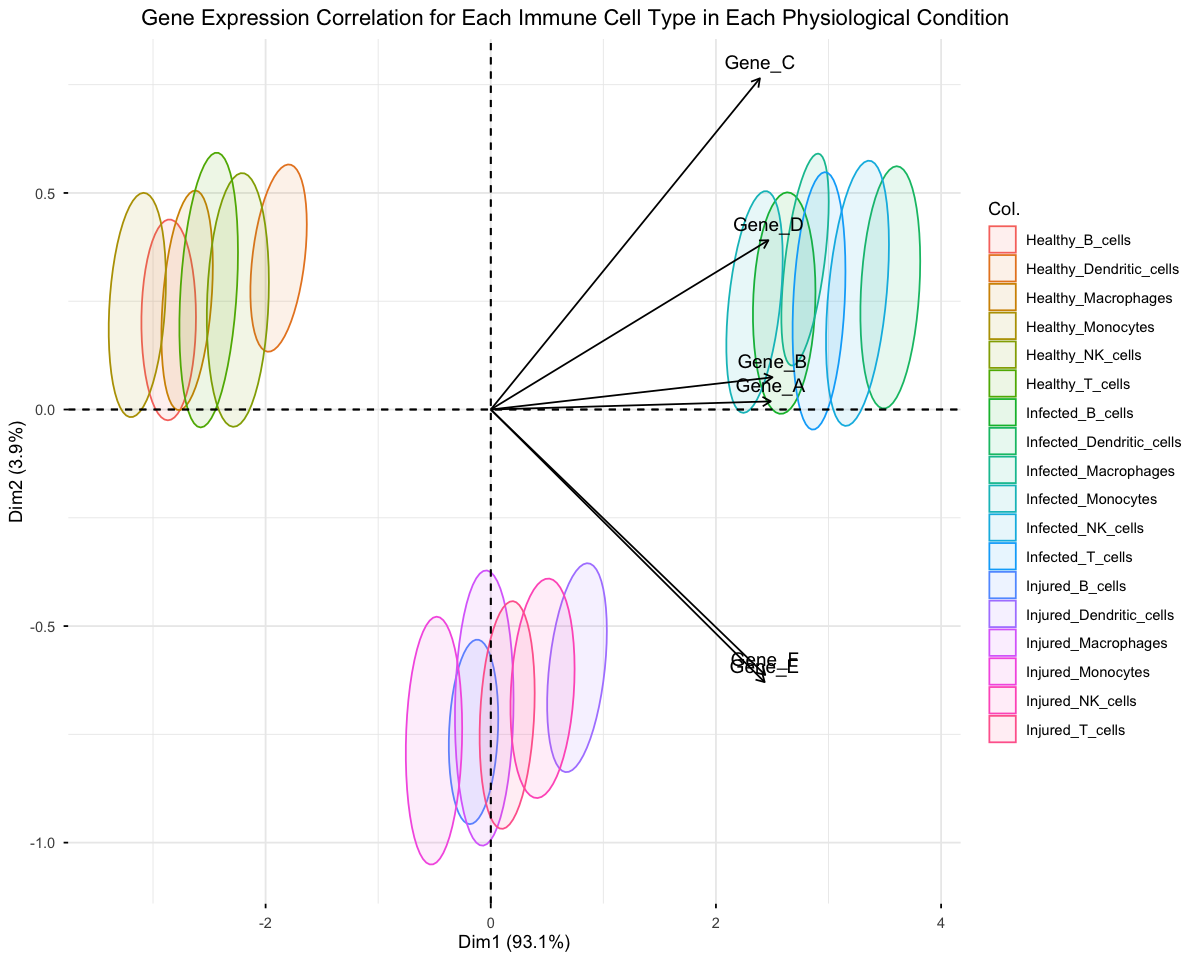

In [178]:
# healthy, injured, and infected population
h_inj_inf = sharks %>% filter(physiological_condition %in% c("Healthy", "Injured", "Infected"))

# PCA on the gene expression levels
h_inj_inf_pca = PCA(h_inj_inf[c("Gene_A","Gene_B","Gene_C","Gene_D","Gene_E","Gene_F")], scale.unit=TRUE, graph=FALSE)

# customize graph size
options(repr.plot.width=10, repr.plot.height=8)

# MDS cloud plot with correlation circle
fviz_pca_biplot(h_inj_inf_pca, geom.ind="None", col.ind=h_inj_inf$group, col.var="black", addEllipses=TRUE, ellipse.level=0.5, title="Gene Expression Correlation for Each Immune Cell Type in Each Physiological Condition") +
    theme(plot.title=element_text(hjust=3))

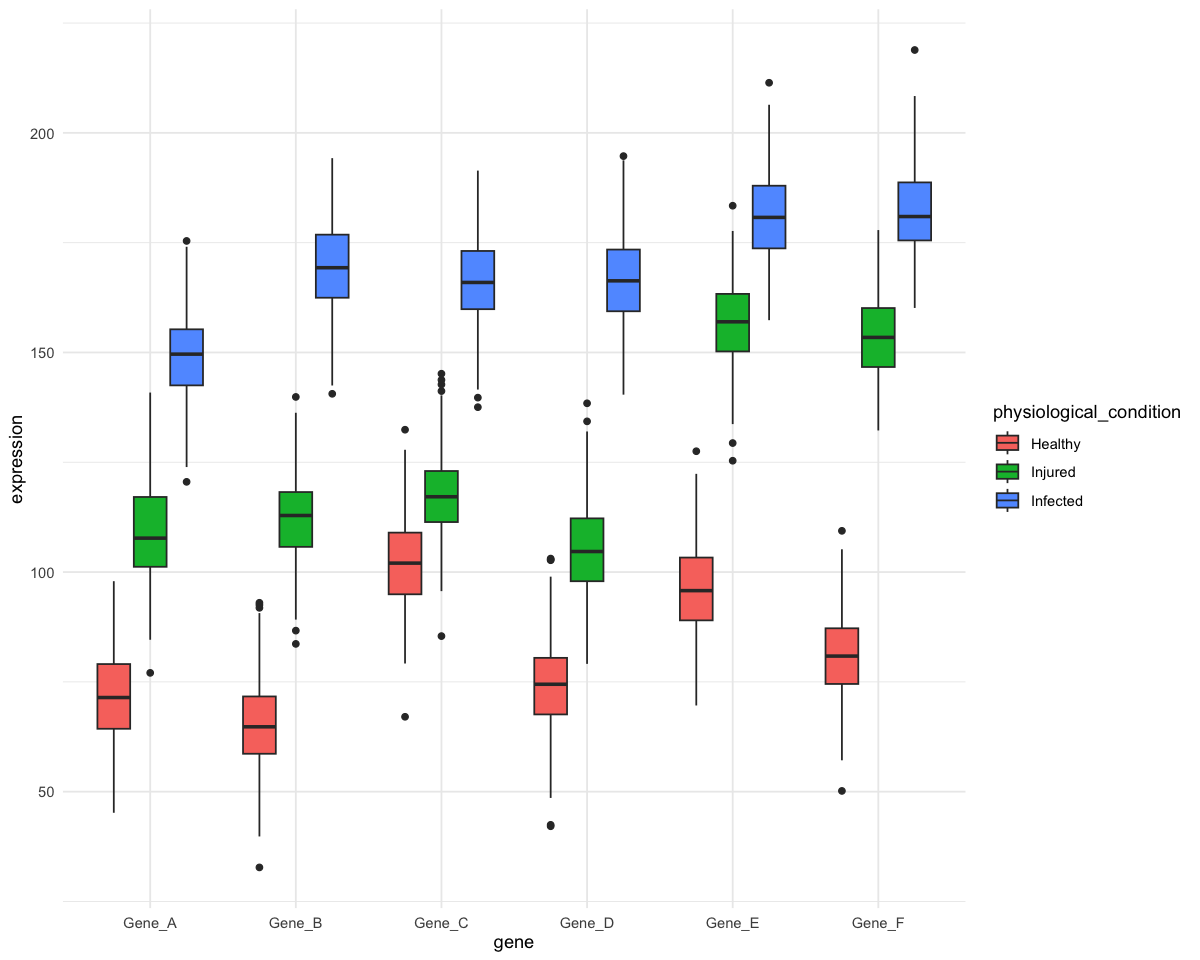

In [188]:
h_inj_inf_genes = shark_genes %>% filter(physiological_condition %in% c("Healthy", "Injured", "Infected"))

ggplot(h_inj_inf_genes, aes(x=gene,y=expression,fill=physiological_condition)) +
    geom_boxplot() +
    theme_minimal()

In [180]:
h_inj_inf_genes %>%
    group_by(gene, physiological_condition) %>%
    summarise(p_value = shapiro.test(expression)$p.value)

`summarise()` has grouped output by 'gene'. You can override using the
`.groups` argument.


gene,physiological_condition,p_value
<chr>,<fct>,<dbl>
Gene_A,Healthy,0.25276498
Gene_A,Injured,0.13715658
Gene_A,Infected,0.52911997
Gene_B,Healthy,0.33330323
Gene_B,Injured,0.78263937
Gene_B,Infected,0.34204193
Gene_C,Healthy,0.93459598
Gene_C,Injured,0.11543153
Gene_C,Infected,0.89057793


# Analysis of Dataset 3 | The Fangs of Immunity : Resilience of the Shark Immune System

## Presentation of the Dataset

1345 observations accounting for 17 variables (not counting the observation ID)

Qualitative Variables 
| variable | values |
| :-: | :-: |
| physiological condition | Healthy, Stressed, Injured, Infected, Recovering |
| immune cell type | Monocytes, Dendritic Cells, T Cells, NK Cells, B Cells, Macrophages |
| habitat location | Indian, Southern, Artic, Pacific, Atlantic |

Quantitative Variables
| variable | min | max | average | standard deviation | variance |
| :-: | :-: | :-: | :-: | :-: | :-: |
| gene expression (6x : A, B, C, D, E, F) | 32.75 | 218.8 | 117.32 | 37.47 | 1402.98 |
| regeneration capacity | 83.2 | 151.9 | 119.0 | 12.55 | 157.48 |
| age (years) | 5.00 | 60.00 | 32.91 | 16.15 | 260.96 |
| immune receptor diversity | 44.9 | 102.7 | 73.4 | 12.79 | 163.60 |
| response to infection | 40.20 | 118.30 | 77.85 | 13.09 | 171.29 |
| inflammation level | 12.80 | 122.90 | 35.97 | 24.35 | 592.81 |
| weight (kg) | 276.2 | 679.7 | 498.1 | 62.05 | 3850.53 |
| resilience score | 98.9 | 174.1 | 128.6 | 13.45 | 180.97 |
| reproduction rate | 6.90 | 25.00 | 14.86 | 5.04 | 25.42 |

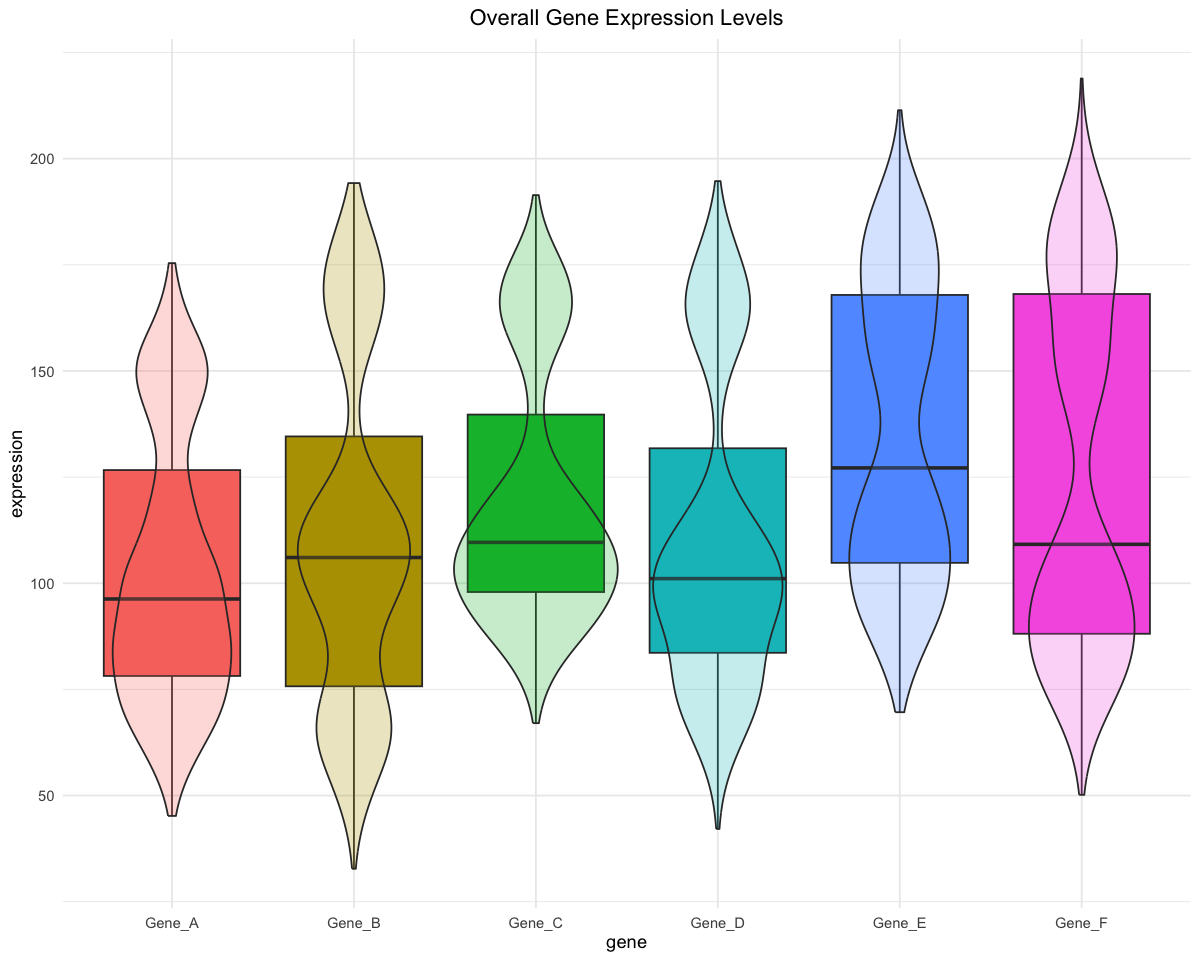

In [181]:
# visualizing expression levels for each gene
ggplot(shark_genes, aes(x=gene,y=expression,fill=gene)) +
    geom_boxplot() +
    geom_violin(alpha=0.25) +
    theme_minimal() +
    theme(
        plot.title=element_text(hjust=0.5),
        legend.position="None"
    ) +
    ggtitle("Overall Gene Expression Levels")

In [182]:
# code obtain information on the dataset
sprintf("%d entries, %d categories (not including )", nrow(sharks), ncol(sharks)-1)
names(sharks)
unique(sharks$physiological_condition)
unique(sharks$immune_cell_type)
unique(sharks$habitat_location)
summary(sharks)

[1] "1345 entries, 18 categories (not including )"

[1] "ID"                        "physiological_condition"  
 [3] "immune_cell_type"          "Gene_A"                   
 [5] "Gene_B"                    "Gene_C"                   
 [7] "Gene_D"                    "Gene_E"                   
 [9] "Gene_F"                    "regeneration_capacity"    
[11] "age_years"                 "immune_receptor_diversity"
[13] "response_to_infection"     "inflammation_level"       
[15] "weight_kg"                 "habitat_location"         
[17] "resilience_score"          "reproduction_rate"        
[19] "group"

[1] Infected   Injured    Healthy    Stressed   Recovering
Levels: Healthy Stressed Injured Infected Recovering

[1] "Monocytes"       "Dendritic_cells" "T_cells"         "NK_cells"       
[5] "B_cells"         "Macrophages"

[1] "Indian"   "Southern" "Arctic"   "Pacific"  "Atlantic"

       ID       physiological_condition immune_cell_type       Gene_A      
 Min.   :   1   Healthy   :387          Length:1345        Min.   : 45.20  
 1st Qu.: 337   Stressed  :201          Class :character   1st Qu.: 78.16  
 Median : 673   Injured   :271          Mode  :character   Median : 96.29  
 Mean   : 673   Infected  :333                             Mean   :102.87  
 3rd Qu.:1009   Recovering:153                             3rd Qu.:126.66  
 Max.   :1345                                              Max.   :175.39  
     Gene_B           Gene_C           Gene_D           Gene_E      
 Min.   : 32.75   Min.   : 67.05   Min.   : 42.13   Min.   : 69.62  
 1st Qu.: 75.73   1st Qu.: 97.93   1st Qu.: 83.62   1st Qu.:104.80  
 Median :106.06   Median :109.63   Median :101.09   Median :127.16  
 Mean   :110.53   Mean   :119.42   Mean   :110.17   Mean   :135.18  
 3rd Qu.:134.58   3rd Qu.:139.72   3rd Qu.:131.79   3rd Qu.:167.90  
 Max.   :194.24   Max.   :191.41   Max.   :194.71   Ma

## Scientific Questions

1. Do the immune reponse profiles differ from one immune cell type to another in the infected condition? If so, how so?

## Analytical Approaches and Methods Used

### Immune Response Profiles of Different Immune Cell Types in the Infected Condition

## Results Obtained

## Conclusions